# Qamomile v0.8.0

---

このリリースでは、[日本語チュートリアル](https://jij-inc.github.io/Qamomile/ja/)の追加により、より多くの人々がアクセスしやすくなり、[OMMX v2](https://jij-inc.github.io/ommx/en/introduction.html)のサポートと新しい量子SDK [CUDA-Q](https://developer.nvidia.com/cuda-q) および [Bloqade-Analog](https://github.com/QuEraComputing/bloqade-analog) の導入により、使いやすさが大幅に向上しました。特にOMMX v2サポートは、最適化問題の統一された形式を提供し、量子最適化アルゴリズムと古典的ソルバーの比較を以前よりも簡単にできるようになったため、ユーザーにとって大きな進歩であると考えています。

他にも影響度が比較的小さいアップデートがあります。詳細については、[リリース](https://github.com/Jij-Inc/Qamomile/releases)および個別のPRをご確認ください。

## ✨ 新機能

### OMMX v2 サポート ([#126](https://github.com/Jij-Inc/Qamomile/pull/126), [#198](https://github.com/Jij-Inc/Qamomile/pull/198))

OMMX v2は、従来のProtocol Bufferベースのアプローチに代わる新しいRustベースの実装により、大幅な性能向上をもたらします（詳細は[OMMX Python SDK 2.0.0](https://github.com/Jij-Inc/ommx/blob/main/docs/ja/release_note/ommx-2.0.0.md)を参照）。このアップデートでは以下が提供されます：

  - **性能向上**: 特に大規模問題における計算量の複雑さの改善
  - **APIの改善**: より直感的でAIに優しいAPI設計
  - **型安全性の向上**: より堅牢な最適化問題処理のためのRustレベルの型チェック

注意点として、OMMX v2はインスタンス処理の性能向上をもたらしますが、回路の実行時間などの量子アルゴリズム側の性能向上を意味するものではありません。

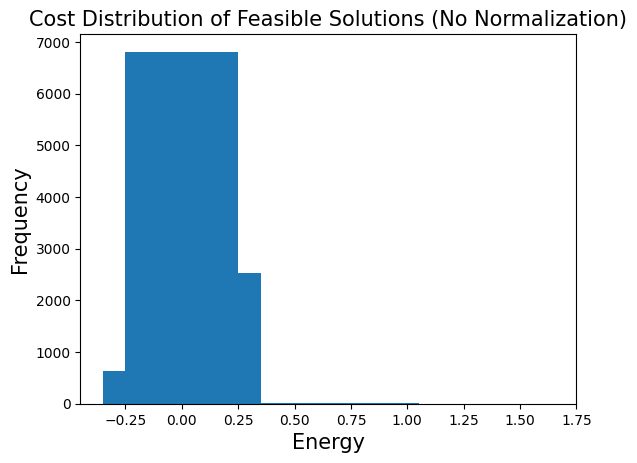

In [1]:
# 必要なライブラリをインポート
from collections import defaultdict

import jijmodeling as jm
import matplotlib.pyplot as plt
import numpy as np
import ommx.v1
import qiskit.primitives as qk_pr
from scipy.optimize import minimize

import qamomile.core as qm
import qamomile.qiskit as qm_qk


# JijModelingで最適化問題を作成
Q = jm.Placeholder("Q", ndim=2)
n = Q.len_at(0, latex="n")
x = jm.BinaryVar("x", shape=(n,))

problem = jm.Problem("qubo")
i, j = jm.Element("i", n), jm.Element("j", n)
problem += jm.sum([i, j], Q[i, j] * x[i] * x[j])

# データをommx.v1.Instanceとしてコンパイル
instance_data = {"Q": [[0.1, 0.2, -0.1], [0.2, 0.3, 0.4], [-0.1, 0.4, 0.0]]}
interpreter = jm.Interpreter(instance_data)
instance: ommx.v1.Instance = interpreter.eval_problem(problem)  # 新機能

# QamomileでQAOAに変換
qaoa_converter = qm.qaoa.QAOAConverter(instance)
p = 5
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=p)
qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()

# Qamomileの回路とハミルトニアンをQiskit形式に変換
qk_transpiler = qm_qk.QiskitTranspiler()
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)
qk_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_hamiltonian)

# Qiskit primitivesを使用してコスト推定関数を定義
estimator = qk_pr.StatevectorEstimator()
cost_history = []
def estimate_cost(param_values):
    try:
        job = estimator.run([(qk_circuit, qk_hamiltonian, param_values)])
        result = job.result()[0]
        cost = result.data["evs"]
        cost_history.append(cost)
        return cost
    except Exception as e:
        print(f"コスト推定中にエラーが発生しました: {e}")
        return np.inf

# COBYLAを使用してQAOAパラメータを最適化
initial_params = np.random.uniform(low=-np.pi / 4, high=np.pi / 4, size=2 * p)
result = minimize(
    estimate_cost,
    initial_params,
    method="COBYLA",
    options={"maxiter": 2000, "tol": 1e-2},
)

# 最適化されたパラメータでQAOA回路を実行
qk_circuit.measure_all()
sampler = qk_pr.StatevectorSampler()
job = sampler.run([(qk_circuit, result.x)], shots=10000)
job_result = job.result()[0]
sampleset: ommx.v1.SampleSet = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])  # 新機能

# エネルギーをグループ化してその頻度を数える辞書を作成
energy_freq = defaultdict(int)
for sample_id in sampleset.sample_ids:
    sample = sampleset.get(sample_id)
    energy_freq[sample.objective] += 1
energies = list(energy_freq.keys())
frequencies = list(energy_freq.values())

# コスト分布を表示
plt.bar(energies, frequencies, width=0.5)
plt.title("Cost Distribution of Feasible Solutions (No Normalization)", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Energy", fontsize=15)
plt.show()

### CUDA-Q サポート ([#143](https://github.com/Jij-Inc/Qamomile/pull/143))
CUDA-Qは、ハイブリッドアプリケーション開発を合理化し、量子コンピューティングにおける生産性とスケーラビリティを促進します。そして今、QamomileフォーマットのCircuitやHamiltonianをCUDA-Qフォーマットにコンパイルできるようになりました！

In [2]:
import cudaq

from qamomile.core.circuit import QuantumCircuit as QamomileCircuit
from qamomile.core.operator import Hamiltonian, X, Y, Z
from qamomile.cudaq.transpiler import CudaqTranspiler

# CudaqTranspilerのインスタンスを作成
cudaq_transpiler = CudaqTranspiler()

# Qamomileを使用してシンプルな量子回路を定義
qc = QamomileCircuit(1)
qc.h(0)
qc.x(0)

# CudaqTranspilerを使用して回路をTranspile
transpiled_circuit = cudaq_transpiler.transpile_circuit(qc)

# Transpileされた回路を描画
print(type(transpiled_circuit))
print(cudaq.draw(transpiled_circuit, []))

# Qamomileを使用してハミルトニアンを作成
hamiltonian = Hamiltonian()
hamiltonian += X(0) * Z(1)
hamiltonian += Y(0) * Y(1) * Z(2) * X(3) * X(4)

# CudaqTranspilerを使用してハミルトニアンをTranspile
transpiled_hamiltonian = cudaq_transpiler.transpile_hamiltonian(hamiltonian)
# Transpileされたハミルトニアンを表示
print(type(transpiled_hamiltonian))
print(transpiled_hamiltonian)

<class 'cudaq.kernel.kernel_builder.PyKernel'>
     ╭───╮╭───╮
q0 : ┤ h ├┤ x ├
     ╰───╯╰───╯

<class 'cudaq.mlir._mlir_libs._quakeDialects.cudaq_runtime.SpinOperator'>
(0+0i) + (1+0i) * X0Z1 + (1+0i) * Y0Y1Z2X3X4


### Bloqade-Analog サポート ([#130](https://github.com/Jij-Inc/Qamomile/pull/130))
Bloqade-AnalogはQuEraの中性原子量子コンピューター上でのアナログ量子プログラムの作成と結果の解析を可能な限りシームレスで柔軟にするために設計されたSDKです。このサポートは、ネイティブなBloqade-Analog統合により中性原子量子コンピューティングの力を解き放ち、Qamomileの範囲をゲートベースの量子デバイスを超えて拡張します。

Overwriting delta from 2.7 to 1.5


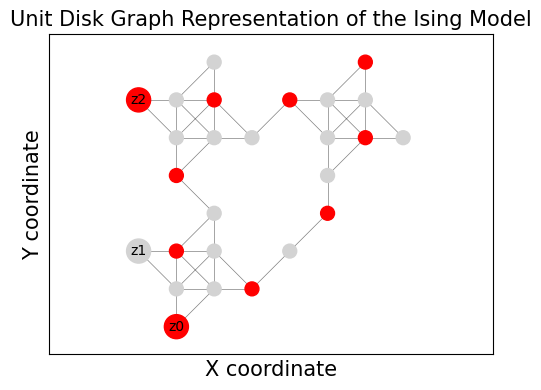

In [4]:
# 必要なライブラリをインポート
import math

from bloqade.analog import start
import jijmodeling as jm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import ommx.v1

from qamomile.core.converters.qaoa import QAOAConverter
from qamomile.udm import Ising_UnitDiskGraph

# 問題を定義
V = jm.Placeholder("V")
E = jm.Placeholder("E", ndim=2)
U = jm.Placeholder("U", ndim=2)
n = jm.BinaryVar("n", shape=(V,))
e = jm.Element("e", belong_to=E)

problem = jm.Problem("QUBO_Hamiltonian")
quadratic_term = jm.sum(e, U[e[0], e[1]] * n[e[0]] * n[e[1]])
problem += quadratic_term

# 問題をデータとともにommx.v1.Instanceとしてコンパイル
quad = {(0, 0): -1.2, (1, 1): -3.2, (2, 2): -1.2, (0, 1): 4.0, (0, 2): -2.0, (1, 2): 3.2}
V_val = 3
E_val = np.array(list(quad.keys()), dtype=int)
U_val = np.zeros((V_val, V_val))
for (i, j), Jij in quad.items():
    U_val[i, j] = U_val[j, i] = Jij
instance = {"V": V_val, "E": E_val, "U": U_val}
compiled_instance: ommx.v1.Instance = jm.Interpreter(instance).eval_problem(problem)

# IsingモデルをUnitDiskGraphクラスにマッピング
udm_converter = QAOAConverter(compiled_instance)
ising_model = udm_converter.ising_encode()
udg = Ising_UnitDiskGraph(ising_model)

# UDMから位置と重みを取得
LOCATION_SCALE = 5.0  # 希望するブロッケード半径とハードウェアに基づいて調整
locations = udg.qubo_result.qubo_grid_to_locations(LOCATION_SCALE)
weights = udg.qubo_result.qubo_result_to_weights()

# プログラムを定義
def solve_ising_bloqade(locations, weights, delta_max=60.0, Omega_max=15.0, t_max=4.0):
    locations_array = np.array(locations)
    centroid = locations_array.mean(axis=0)
    centered_locations = locations_array - centroid
    locations = list(map(tuple, centered_locations))

    lw = len(weights)
    weights_norm = [x / max(weights) for x in weights]

    def sine_waveform(t):
        return Omega_max * math.sin(math.pi * t / t_max) ** 2

    def linear_detune_waveform(t):
        return delta_max * (2 * t / t_max - 1)

    program = (
        start.add_position(locations)
        .rydberg.detuning.scale(weights_norm)
        .fn(linear_detune_waveform, t_max)
        .amplitude.uniform.fn(sine_waveform, t_max)
    )

    return program
program = solve_ising_bloqade(locations, weights)

# シミュレーションを実行
blockade_radius = LOCATION_SCALE * 1.5  # ブロッケード半径は対角ノードをカバーするように設定（1: sqrt(2)）
emu_results = program.bloqade.python().run(
    shots=10000, solver_name="dop853", blockade_radius=blockade_radius
)
report = emu_results.report()
counts = report.counts()[0]
sorted_counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}

# NetworkXとMatplotlibを使用して結果を可視化
G_vis = udg.networkx_graph
pos = nx.get_node_attributes(G_vis, "pos")
# ビット値に基づいてノードの色とサイズを設定
bitstr = list(sorted_counts.items())[:2][0][0]
node_colors = ["red" if b == "0" else "lightgray" for b in bitstr]
node_sizes = [300 if i in udg.pins else 100 for i in G_vis.nodes()]

plt.figure(figsize=(5, 4))
nx.draw_networkx_nodes(G_vis, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G_vis, pos, width=0.5, alpha=0.5)

# ピンに元の変数インデックスでラベルを付ける
pin_labels = {pin: f"z{i}" for i, pin in enumerate(udg.pins)}  # Isingスピンにz_iを使用
nx.draw_networkx_labels(G_vis, pos, labels=pin_labels, font_size=10)

plt.title("Unit Disk Graph Representation of the Ising Model", fontsize=15)
plt.xlabel("X coordinate", fontsize=15)
plt.ylabel("Y coordinate", fontsize=15)
plt.axis("equal")  # Ensure aspect ratio is maintained
plt.tight_layout()
plt.show()

## 🐛 バグ修正

詳細については、[リリース](https://github.com/Jij-Inc/Qamomile/releases)をご確認ください。

## 🛠️ その他の変更と改善

詳細については、[リリース](https://github.com/Jij-Inc/Qamomile/releases)をご確認ください。

## 💬 フィードバック
これらの新機能により、Qamomileは複数の量子SDKに同じ方法でアクセスし、古典的ソルバーと結果を比較できる強力なツールになりました。Qamomile 0.8.0をぜひお試しください！


フィードバックやバグ報告は、[GitHub Issues](https://github.com/Jij-Inc/Qamomile/issues)にお送りください。